### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import qutip as qt
from src import code_simulator, code, noise

### Parameters

In [2]:
loss_noise_values = [0, 0.01, 0.03, 0.05, 0.1]
dephasing_noise_values = [0, 0.01, 0.03, 0.05, 0.1]
rotation_symmetries = [2, 3, 4]
average_photon_numbers = range(1, 4)
number_of_random_code_trials = 40

### Fidelities of Trivial Code

In [3]:
trivial_fidelities = np.zeros((len(loss_noise_values), len(dephasing_noise_values)))
for i, loss_noise_value in enumerate(loss_noise_values):
	for j, dephasing_noise_value in enumerate(dephasing_noise_values):
		combined_noise = noise.Noise(2, [("dephasing", dephasing_noise_value), ("loss", loss_noise_value)])
		trivial_fidelities[i,j] = code_simulator.get_fidelity_of_code_under_noise(code.trivial_code, combined_noise, False)

### Fidelities of Binomial Code

In [4]:
binomial_fidelities = np.zeros((len(loss_noise_values), len(dephasing_noise_values), len(rotation_symmetries), len(average_photon_numbers)))
for i, loss_noise_value in enumerate(loss_noise_values):
	for j, dephasing_noise_value in enumerate(dephasing_noise_values):
		for k, rotation_symmetry in enumerate(rotation_symmetries):
			for l, average_photon_number in enumerate(average_photon_numbers):
				dimension = (average_photon_number + 2) * rotation_symmetry
				combined_noise = noise.Noise(dimension, [("dephasing", dephasing_noise_value), ("loss", loss_noise_value)])
				binomial_code = code.get_binomial_code(rotation_symmetry, average_photon_number, dimension)
				binomial_fidelities[i,j,k,l] = code_simulator.get_fidelity_of_code_under_noise(binomial_code, combined_noise, True)

### Binomial Code Optimal Fidelities in Each Region

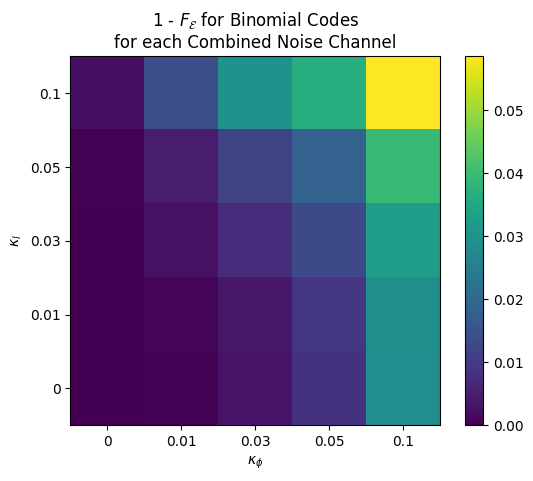

In [5]:
best_binomial_fidelities_per_region = np.max(binomial_fidelities.reshape((len(loss_noise_values), len(dephasing_noise_values), -1)), -1)

plt.figure()
plt.imshow(1 - best_binomial_fidelities_per_region, origin="lower")
ax = plt.gca()
ax.set_yticks(range(len(loss_noise_values)), loss_noise_values)
ax.set_xticks(range(len(dephasing_noise_values)), dephasing_noise_values)
plt.title("1 - $F_\\mathcal{E}$ for Binomial Codes\nfor each Combined Noise Channel")
plt.ylabel("$\\kappa_l$")
plt.xlabel("$\\kappa_\\phi$")
plt.colorbar()
plt.show()

### Fidelities of Two-Expanded Haar Random

In [6]:
random_fidelities = np.zeros((len(loss_noise_values), len(dephasing_noise_values), len(rotation_symmetries), len(average_photon_numbers), number_of_random_code_trials))
for i, loss_noise_value in enumerate(loss_noise_values):
	for j, dephasing_noise_value in enumerate(dephasing_noise_values):
		for k, rotation_symmetry in enumerate(rotation_symmetries):
			for l, average_photon_number in enumerate(average_photon_numbers):
				for m in range(number_of_random_code_trials):
					dimension = (average_photon_number + 2) * rotation_symmetry
					combined_noise = noise.Noise(dimension, [("dephasing", dephasing_noise_value), ("loss", loss_noise_value)])
					random_code = code.make_two_expanded_haar_random_code(rotation_symmetry, average_photon_number, dimension)
					random_fidelities[i,j,k,l,m] = code_simulator.get_fidelity_of_code_under_noise(random_code, combined_noise, True)

### Random Code Optimal Fidelities in Each Region

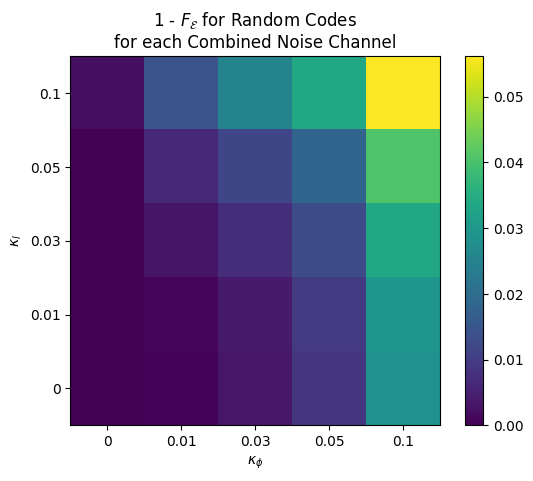

In [7]:
best_random_fidelities_per_region = np.max(random_fidelities.reshape((len(loss_noise_values), len(dephasing_noise_values), -1)), -1)

plt.figure()
plt.imshow(1 - best_random_fidelities_per_region, origin="lower")
ax = plt.gca()
ax.set_yticks(range(len(loss_noise_values)), loss_noise_values)
ax.set_xticks(range(len(dephasing_noise_values)), dephasing_noise_values)
plt.title("1 - $F_\\mathcal{E}$ for Random Codes\nfor each Combined Noise Channel")
plt.ylabel("$\\kappa_l$")
plt.xlabel("$\\kappa_\\phi$")
plt.colorbar()
plt.show()

### Best Code in Each Region

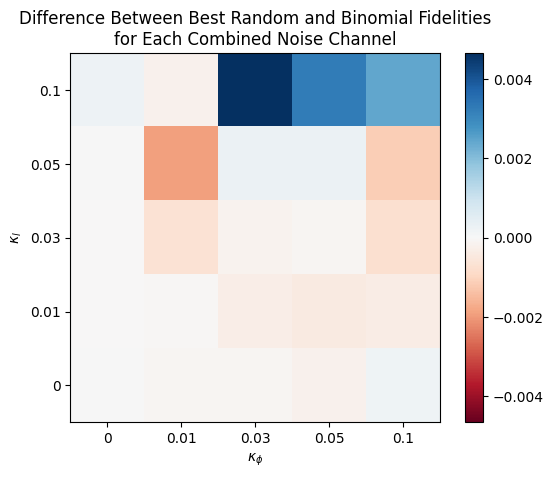

In [8]:
fidelity_difference = best_random_fidelities_per_region - best_binomial_fidelities_per_region

cmap = plt.get_cmap("RdBu")
most_extreme_fidelity_difference = max(np.max(fidelity_difference), np.max(-fidelity_difference))
normalizer = matplotlib.colors.Normalize(-most_extreme_fidelity_difference, most_extreme_fidelity_difference)

plt.figure()
plt.imshow(fidelity_difference, origin="lower", cmap=cmap, norm=normalizer)
ax = plt.gca()
ax.set_yticks(range(len(loss_noise_values)), loss_noise_values)
ax.set_xticks(range(len(dephasing_noise_values)), dephasing_noise_values)
plt.title("Difference Between Best Random and Binomial Fidelities\nfor Each Combined Noise Channel")
plt.ylabel("$\\kappa_l$")
plt.xlabel("$\\kappa_\\phi$")
plt.colorbar(matplotlib.cm.ScalarMappable(norm=normalizer, cmap=cmap), ax=plt.gca())
plt.show()